In [1]:
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.auto import tqdm
import numpy as np

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
df_train = pd.read_csv("archive\\Train.csv")
df_test = pd.read_csv("archive\\Test.csv")
df_train["split"], df_test["split"] = "train", "test"
df = pd.concat([df_train, df_test])
df = df.reset_index(drop=True)

In [4]:
wd = os.getcwd() + "\\archive\\"
path = wd + df_train["Path"][0]

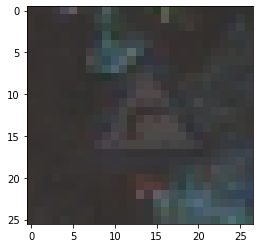

In [5]:
y = cv2.imread(path)
plt.imshow(y)

In [6]:
df_train

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,split
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,train
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,train
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,train
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,train
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,train
...,...,...,...,...,...,...,...,...,...
39204,52,56,5,6,47,51,42,Train/42/00042_00007_00025.png,train
39205,56,58,5,5,51,53,42,Train/42/00042_00007_00026.png,train
39206,58,62,5,6,53,57,42,Train/42/00042_00007_00027.png,train
39207,63,69,5,7,58,63,42,Train/42/00042_00007_00028.png,train


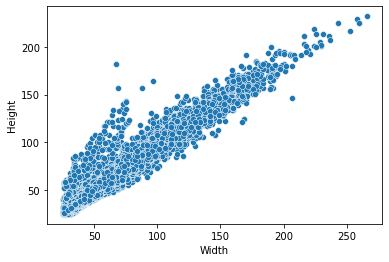

In [7]:
import seaborn as sns

sns.scatterplot(x=df["Width"],y=df["Height"])
plt.show()

<AxesSubplot:ylabel='Density'>

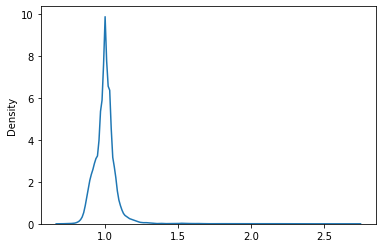

In [8]:
sns.kdeplot(df["Height"]/df["Width"])

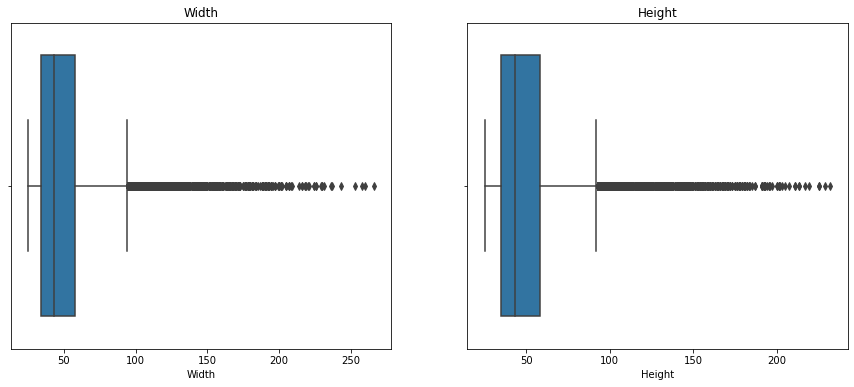

In [9]:
fig, axs = plt.subplots(ncols=2,figsize=(15, 6))
sns.boxplot(x=df["Width"], ax=axs[0])
axs[0].title.set_text("Width")
sns.boxplot(x=df["Height"], ax=axs[1])
axs[1].title.set_text("Height")

(44, 49, 3)


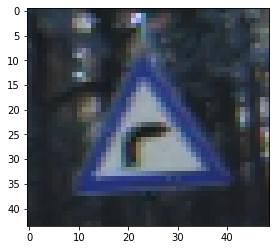

In [10]:
path2 = wd + df["Path"][199]
image2 = cv2.imread(path2)
print(image2.shape)
plt.imshow(image2)

(50, 50, 3)


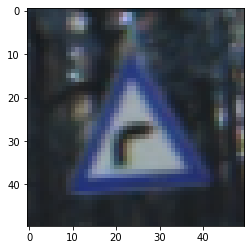

In [11]:
a = cv2.resize(image2, (50, 50))
print(a.shape)
plt.imshow(a)

In [12]:
int((df["Height"].mean() + df["Width"].mean())/2)

50

In [13]:
df_train, df_test = df[df["split"]=="train"], df[df["split"]=="test"]
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [14]:
def image_prep(df, resize=True, shape=(50,50)):
    images = []
    labels = []
    for i in tqdm(range(df["Path"].shape[0])):
        path = wd + df["Path"][i]
        label = df["ClassId"][i]
        image = cv2.imread(path)
        if resize:
            image = cv2.resize(image, shape)
        if image is not None:
            images.append(image)
            labels.append(label)
    return images, labels

In [15]:
from sklearn.utils import shuffle

X_train, y_train  = image_prep(df_train)
X_test, y_test = image_prep(df_test)
X_train, y_train = shuffle(X_train, y_train)

  0%|          | 0/39209 [00:00<?, ?it/s]

  0%|          | 0/12630 [00:00<?, ?it/s]

In [16]:
def construct_image_batch(image_group, BATCH_SIZE):
    # get the max image shape
    max_shape = (50,50,3)
    # construct an image batch object
    image_batch = np.zeros((BATCH_SIZE,) + max_shape, dtype='float16')
    # copy all images to the upper left part of the image batch object
    for image_index, image in tqdm(enumerate(image_group)):
        image_batch[image_index, :image.shape[0], :image.shape[1], :image.shape[2]] = image

    return image_batch

In [17]:
X_train_fixed = construct_image_batch(X_train, len(X_train))
X_test_fixed = construct_image_batch(X_test, len(X_test))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [18]:
y_train, y_test = np.array(y_train), np.array(y_test)

In [19]:
np.unique(y_train).shape

(43,)

In [20]:
from tensorflow import keras
import tensorflow as tf
from keras.callbacks import ModelCheckpoint


def CNN_model(X_train, X_test, y_train, y_test):
    
    # Input layer
    input_shape = (50,50,3)

    model = keras.Sequential([

        keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=input_shape),
        keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="same"),
        keras.layers.BatchNormalization(),

        keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=input_shape),
        keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="same"),
        keras.layers.BatchNormalization(),

        keras.layers.Conv2D(filters=32, kernel_size=(2,2), activation="relu", input_shape=input_shape),
        keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same"),
        keras.layers.BatchNormalization(),

        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(256,activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout((0.25)),
        keras.layers.Dense(128,activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout((0.25)),
        keras.layers.Dense(64,activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout((0.25)),  
        keras.layers.Dense(43, activation="softmax")
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    
    filepath = 'my_best_model.hdf5'
    checkpoint = ModelCheckpoint(filepath=filepath, 
                                 monitor='val_loss',
                                 verbose=1, 
                                 save_best_only=True,
                                 mode='min')
    callbacks = [checkpoint]
    
    model.fit(X_train,y_train, validation_split=0.2, epochs=100, verbose=1, batch_size=64, callbacks=callbacks)
    
    _, accuracy = model.evaluate(X_test, y_test)

    print("Accuracy: %.2f" % (accuracy*100))
    
    return model

In [21]:
model = CNN_model(X_train_fixed,X_test_fixed,y_train,y_test)

Epoch 1/100
490/491 [============================>.] - ETA: 0s - loss: 3.8090 - accuracy: 0.0828
Epoch 1: val_loss improved from inf to 3.17587, saving model to my_best_model.hdf5
491/491 [==============================] - 45s 89ms/step - loss: 3.8088 - accuracy: 0.0828 - val_loss: 3.1759 - val_accuracy: 0.1723
Epoch 2/100
490/491 [============================>.] - ETA: 0s - loss: 3.1958 - accuracy: 0.1799
Epoch 2: val_loss improved from 3.17587 to 2.74216, saving model to my_best_model.hdf5
491/491 [==============================] - 41s 84ms/step - loss: 3.1958 - accuracy: 0.1799 - val_loss: 2.7422 - val_accuracy: 0.2663
Epoch 3/100
490/491 [============================>.] - ETA: 0s - loss: 2.8152 - accuracy: 0.2531
Epoch 3: val_loss improved from 2.74216 to 2.43934, saving model to my_best_model.hdf5
491/491 [==============================] - 40s 82ms/step - loss: 2.8152 - accuracy: 0.2531 - val_loss: 2.4393 - val_accuracy: 0.3318
Epoch 4/100
490/491 [============================>.] 

491/491 [==============================] - 42s 85ms/step - loss: 0.7253 - accuracy: 0.7718 - val_loss: 0.5484 - val_accuracy: 0.8341
Epoch 28/100
490/491 [============================>.] - ETA: 0s - loss: 0.7061 - accuracy: 0.7777
Epoch 28: val_loss did not improve from 0.54838
491/491 [==============================] - 42s 86ms/step - loss: 0.7066 - accuracy: 0.7776 - val_loss: 0.5820 - val_accuracy: 0.8173
Epoch 29/100
490/491 [============================>.] - ETA: 0s - loss: 0.6953 - accuracy: 0.7822
Epoch 29: val_loss improved from 0.54838 to 0.47874, saving model to my_best_model.hdf5
491/491 [==============================] - 42s 85ms/step - loss: 0.6954 - accuracy: 0.7821 - val_loss: 0.4787 - val_accuracy: 0.8489
Epoch 30/100
490/491 [============================>.] - ETA: 0s - loss: 0.6558 - accuracy: 0.7923
Epoch 30: val_loss did not improve from 0.47874
491/491 [==============================] - 40s 82ms/step - loss: 0.6565 - accuracy: 0.7922 - val_loss: 0.4845 - val_accurac

Epoch 55/100
490/491 [============================>.] - ETA: 0s - loss: 0.3229 - accuracy: 0.8975
Epoch 55: val_loss did not improve from 0.20012
491/491 [==============================] - 37s 76ms/step - loss: 0.3229 - accuracy: 0.8975 - val_loss: 0.2368 - val_accuracy: 0.9262
Epoch 56/100
490/491 [============================>.] - ETA: 0s - loss: 0.3170 - accuracy: 0.9019
Epoch 56: val_loss did not improve from 0.20012
491/491 [==============================] - 38s 77ms/step - loss: 0.3171 - accuracy: 0.9018 - val_loss: 0.2044 - val_accuracy: 0.9365
Epoch 57/100
490/491 [============================>.] - ETA: 0s - loss: 0.3193 - accuracy: 0.8996
Epoch 57: val_loss did not improve from 0.20012
491/491 [==============================] - 38s 76ms/step - loss: 0.3194 - accuracy: 0.8995 - val_loss: 0.2023 - val_accuracy: 0.9352
Epoch 58/100
490/491 [============================>.] - ETA: 0s - loss: 0.3029 - accuracy: 0.9045
Epoch 58: val_loss improved from 0.20012 to 0.17978, saving model

In [22]:
model.save("capstone_rgb.h5", save_format = "h5")